# 데이터 불러오기

In [18]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [19]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [20]:
plt.rc('font', family='NanumBarunGothic')

In [21]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/KDT/본 프로젝트


In [22]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [23]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [24]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [25]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [26]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()
df_sin_quarter

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,독서실,신촌동,169054586,18,1,0
1,2017-1,서비스,교육,스포츠강습,신촌동,795837623,23,1,0
2,2017-1,서비스,교육,예술학원,신촌동,1162571945,28,1,0
3,2017-1,서비스,교육,외국어학원,신촌동,3196308868,24,2,2
4,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
...,...,...,...,...,...,...,...,...,...
1339,2022-4,외식,식사류,패스트푸드점,신촌동,3057584360,83,0,4
1340,2022-4,외식,식사류,한식음식점,신촌동,29617724330,435,8,12
1341,2022-4,외식,주류,호프-간이주점,신촌동,7366806532,171,1,6
1342,2022-4,외식,카페/베이커리,제과점,신촌동,1302230221,48,3,2


# 패스트푸드점

In [27]:
# 패스트푸드점만 남기기
sin_junkfood = df_sin_quarter[df_sin_quarter.업종명 == '패스트푸드점'].reset_index().drop('index', axis=1)
sin_junkfood

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,외식,식사류,패스트푸드점,신촌동,4187187100,85,7,3
1,2017-2,외식,식사류,패스트푸드점,신촌동,4835625661,88,3,0
2,2017-3,외식,식사류,패스트푸드점,신촌동,4380363389,88,2,2
3,2017-4,외식,식사류,패스트푸드점,신촌동,4510821236,88,1,1
4,2018-1,외식,식사류,패스트푸드점,신촌동,3934265191,86,1,3
5,2018-2,외식,식사류,패스트푸드점,신촌동,5330616280,86,1,1
6,2018-3,외식,식사류,패스트푸드점,신촌동,4399869669,86,2,2
7,2018-4,외식,식사류,패스트푸드점,신촌동,4899827210,84,3,5
8,2019-1,외식,식사류,패스트푸드점,신촌동,4804562568,79,2,7
9,2019-2,외식,식사류,패스트푸드점,신촌동,4880018931,74,1,2


## 지표 만들기 : 성장성, 시장성, 순점포증감률

In [28]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_junkfood['성장성'] = sin_junkfood['분기당_매출_금액'] / sin_junkfood['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_junkfood['성장성'][0] = 1

sin_junkfood

<ipython-input-28-7145f9a2ec05>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_junkfood['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,외식,식사류,패스트푸드점,신촌동,4187187100,85,7,3,1.000000
1,2017-2,외식,식사류,패스트푸드점,신촌동,4835625661,88,3,0,1.154863
2,2017-3,외식,식사류,패스트푸드점,신촌동,4380363389,88,2,2,0.905852
3,2017-4,외식,식사류,패스트푸드점,신촌동,4510821236,88,1,1,1.029782
4,2018-1,외식,식사류,패스트푸드점,신촌동,3934265191,86,1,3,0.872184
5,2018-2,외식,식사류,패스트푸드점,신촌동,5330616280,86,1,1,1.354920
6,2018-3,외식,식사류,패스트푸드점,신촌동,4399869669,86,2,2,0.825396
7,2018-4,외식,식사류,패스트푸드점,신촌동,4899827210,84,3,5,1.113630
8,2019-1,외식,식사류,패스트푸드점,신촌동,4804562568,79,2,7,0.980558
9,2019-2,외식,식사류,패스트푸드점,신촌동,4880018931,74,1,2,1.015705


In [29]:
# 개업률, 폐업률, 순점포증감률 추가

sin_junkfood['개업률'] = (sin_junkfood['개업점포수'] / sin_junkfood['총 점포수']) * 100
sin_junkfood['폐업률'] = (sin_junkfood['폐업점포수'] / sin_junkfood['총 점포수']) * 100
sin_junkfood['순점포증감률'] = ((sin_junkfood['개업점포수'] - sin_junkfood['폐업점포수']) / sin_junkfood['총 점포수']) * 100

# sin_junkfood

In [30]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 패스트푸드점만 남기기
seo_junkfood = df_seo_quarter[df_seo_quarter['업종명'] == '패스트푸드점'].reset_index()

################################################################################################################################################################################################

sin_junkfood['시장성'] = (sin_junkfood['분기당_매출_금액'] / sin_junkfood['총 점포수']) - (seo_junkfood['분기당_매출_금액'] / seo_junkfood['총 점포수'])

sin_junkfood = sin_junkfood[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_junkfood

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,패스트푸드점,4187187100,1.000000,4.705882,-6.666712e+06
1,2017-2,패스트푸드점,4835625661,1.154863,3.409091,-4.077555e+06
2,2017-3,패스트푸드점,4380363389,0.905852,0.000000,-1.332540e+06
3,2017-4,패스트푸드점,4510821236,1.029782,0.000000,-1.383189e+06
4,2018-1,패스트푸드점,3934265191,0.872184,-2.325581,-1.389288e+06
5,2018-2,패스트푸드점,5330616280,1.354920,0.000000,3.468321e+06
6,2018-3,패스트푸드점,4399869669,0.825396,0.000000,2.827236e+05
7,2018-4,패스트푸드점,4899827210,1.113630,-2.380952,1.811155e+06
8,2019-1,패스트푸드점,4804562568,0.980558,-6.329114,5.300686e+06
9,2019-2,패스트푸드점,4880018931,1.015705,-1.351351,8.028357e+06


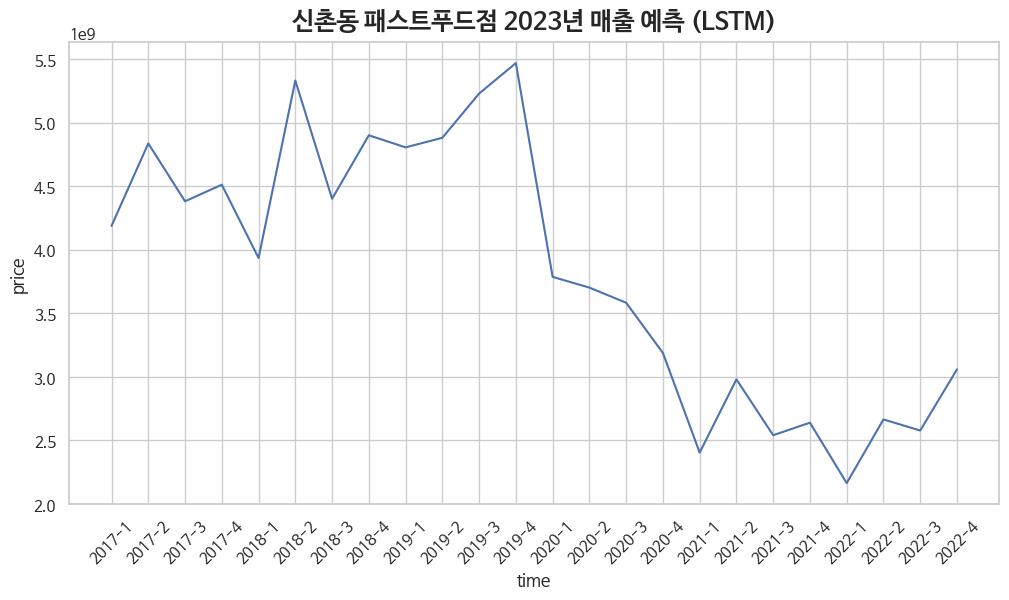

In [32]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화

sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['분기당_매출_금액'])
plt.title('신촌동 패스트푸드점 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [33]:
### X / y 데이터 생성
X = sin_junkfood[['성장성', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -6.666712e+06  4.705882
1   1.154863 -4.077555e+06  3.409091
2   0.905852 -1.332540e+06  0.000000
3   1.029782 -1.383189e+06  0.000000
4   0.872184 -1.389288e+06 -2.325581
5   1.354920  3.468321e+06  0.000000
6   0.825396  2.827236e+05  0.000000
7   1.113630  1.811155e+06 -2.380952
8   0.980558  5.300686e+06 -6.329114
9   1.015705  8.028357e+06 -1.351351
10  1.071350  8.202359e+06  0.000000
11  1.045784  1.122510e+07  0.000000
12  0.692378  1.805991e+06  1.123596
13  0.977722  2.406211e+06 -2.409639
14  0.967866  2.611041e+06 -2.409639
15  0.889712  2.644881e+06 -1.219512
16  0.754105  6.835053e+03 -1.234568
17  1.239623  2.270456e+06  5.813953
18  0.852514  8.195975e+05 -2.409639
19  1.038847  9.447096e+05  1.123596
20  0.819832 -1.669795e+06 -1.149425
21  1.231578 -9.062759e+05  1.149425
22  0.967198 -2.253539e+06  1.149425
23  1.186543  1.117470e+06 -4.819277
---------------------------------------------------------------------------

In [34]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [35]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [36]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [37]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.41479707 0.24665884 0.61586904]
 [0.74586174 0.4350696  0.12433735]]


In [38]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [39]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [40]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6908
Epoch 1: val_loss improved from inf to 0.11693, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.6908 - val_loss: 0.1169
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6718
Epoch 2: val_loss improved from 0.11693 to 0.10978, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.6718 - val_loss: 0.1098
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6532
Epoch 3: val_loss improved from 0.10978 to 0.10300, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.6532 - val_loss: 0.1030
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6352
Epoch 4: val_loss improved from 0.10300 to 0.09656, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.6352 - val_loss: 0.0966
Epoch 5/100
1/1 [=================

In [41]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 834ms/step
[[0.24857327]
 [0.26843414]
 [0.25638902]
 [0.30203605]]


In [42]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.000000,0.248573
2022-2,0.151614,0.268434
2022-3,0.125165,0.256389
2022-4,0.270644,0.302036


In [43]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_junkfood의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.000000,0.248573,2163303723,2.984658e+09,-821353941.0
2022-2,0.151614,0.268434,2664276916,3.050284e+09,-386006604.0
2022-3,0.125165,0.256389,2576884633,3.010483e+09,-433598311.0
2022-4,0.270644,0.302036,3057584360,3.161313e+09,-103728920.0


### 결과

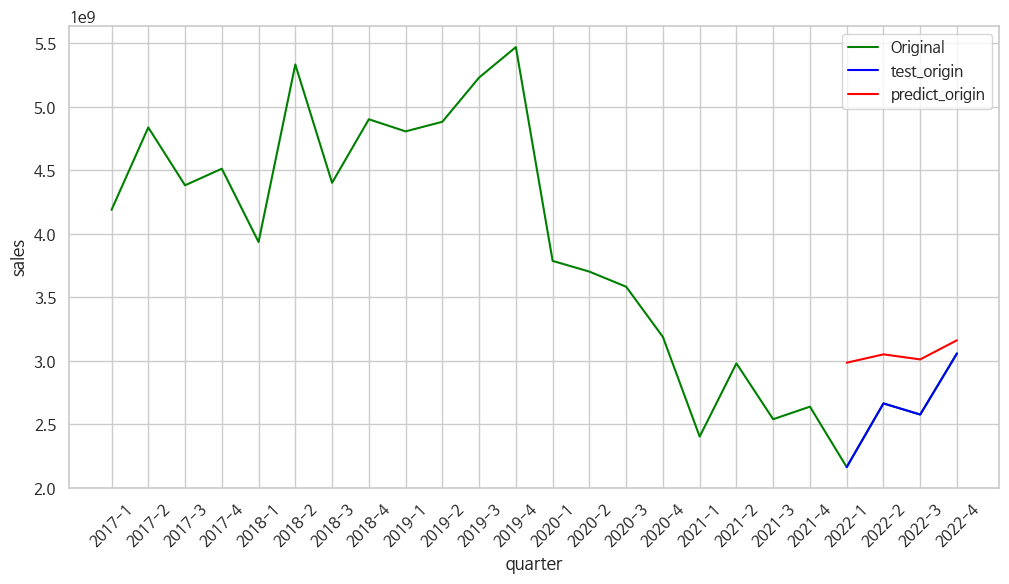

In [44]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [45]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -4.361719e+08
std      2.951874e+08
min     -8.213539e+08
25%     -5.305372e+08
50%     -4.098025e+08
75%     -3.154372e+08
max     -1.037289e+08
dtype: float64

In [46]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 23ms/step
[[0.26391128]]
--------------------------------------------------------------------------------
예측된 매출  : 3035338752.0 


## 23년 1분기 성장성 예측

In [47]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

     분기당_매출_금액           시장성    순점포증감률
0   4187187100 -6.666712e+06  4.705882
1   4835625661 -4.077555e+06  3.409091
2   4380363389 -1.332540e+06  0.000000
3   4510821236 -1.383189e+06  0.000000
4   3934265191 -1.389288e+06 -2.325581
5   5330616280  3.468321e+06  0.000000
6   4399869669  2.827236e+05  0.000000
7   4899827210  1.811155e+06 -2.380952
8   4804562568  5.300686e+06 -6.329114
9   4880018931  8.028357e+06 -1.351351
10  5228206221  8.202359e+06  0.000000
11  5467576400  1.122510e+07  0.000000
12  3785628101  1.805991e+06  1.123596
13  3701290402  2.406211e+06 -2.409639
14  3582353768  2.611041e+06 -2.409639
15  3187264236  2.644881e+06 -1.219512
16  2403530600  6.835053e+03 -1.234568
17  2979472413  2.270456e+06  5.813953
18  2540041933  8.195975e+05 -2.409639
19  2638716109  9.447096e+05  1.123596
20  2163303723 -1.669795e+06 -1.149425
21  2664276916 -9.062759e+05  1.149425
22  2576884633 -2.253539e+06  1.149425
23  3057584360  1.117470e+06 -4.819277
-------------------------

In [48]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [49]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [50]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.12516549 0.24665884 0.61586904]
 [0.27064372 0.4350696  0.12433735]]


In [51]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [52]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [53]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3204
Epoch 1: val_loss improved from inf to 0.19643, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3204 - val_loss: 0.1964
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3071
Epoch 2: val_loss improved from 0.19643 to 0.18833, saving model to stock_model.h5
1/1 [==============================] - 0s 129ms/step - loss: 0.3071 - val_loss: 0.1883
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2943
Epoch 3: val_loss improved from 0.18833 to 0.18061, saving model to stock_model.h5
1/1 [==============================] - 0s 136ms/step - loss: 0.2943 - val_loss: 0.1806
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2820
Epoch 4: val_loss improved from 0.18061 to 0.17323, saving model to stock_model.h5
1/1 [==============================] - 0s 119ms/step - loss: 0.2820 - val_loss: 0.1732
Epoch 5/100
1/1 [==============

In [54]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 836ms/step
[[0.24752213]
 [0.25502393]
 [0.2366287 ]
 [0.2679541 ]]


In [55]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.192371,0.247522
2022-2,0.813835,0.255024
2022-3,0.414797,0.236629
2022-4,0.745862,0.267954


In [56]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 3].values       # 성장성이 sin_junkfood의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.192371,0.247522,0.819832,0.856372,-0.036540
2022-2,0.813835,0.255024,1.231578,0.861342,0.370236
2022-3,0.414797,0.236629,0.967198,0.849154,0.118044
2022-4,0.745862,0.267954,1.186543,0.869909,0.316634


### 결과

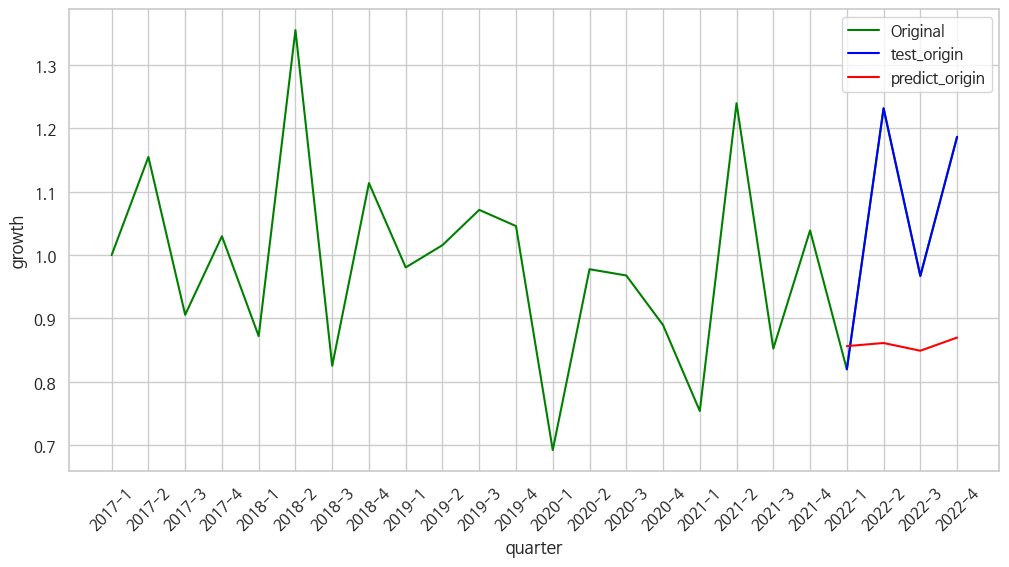

In [57]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [58]:
## error의 요약 통계량
error.describe()

count    4.000000
mean     0.192094
std      0.187084
min     -0.036540
25%      0.079398
50%      0.217339
75%      0.330035
max      0.370236
dtype: float64

In [59]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 23ms/step
[[0.25214028]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8594314455986023 


## 23년 1분기 시장성 예측

In [60]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_junkfood[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_junkfood.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성   분기당_매출_금액    순점포증감률
0   1.000000  4187187100  4.705882
1   1.154863  4835625661  3.409091
2   0.905852  4380363389  0.000000
3   1.029782  4510821236  0.000000
4   0.872184  3934265191 -2.325581
5   1.354920  5330616280  0.000000
6   0.825396  4399869669  0.000000
7   1.113630  4899827210 -2.380952
8   0.980558  4804562568 -6.329114
9   1.015705  4880018931 -1.351351
10  1.071350  5228206221  0.000000
11  1.045784  5467576400  0.000000
12  0.692378  3785628101  1.123596
13  0.977722  3701290402 -2.409639
14  0.967866  3582353768 -2.409639
15  0.889712  3187264236 -1.219512
16  0.754105  2403530600 -1.234568
17  1.239623  2979472413  5.813953
18  0.852514  2540041933 -2.409639
19  1.038847  2638716109  1.123596
20  0.819832  2163303723 -1.149425
21  1.231578  2664276916  1.149425
22  0.967198  2576884633  1.149425
23  1.186543  3057584360 -4.819277
--------------------------------------------------------------------------------
             시장성
0  -6.666712e+06
1  -4.0775

In [61]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [62]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [63]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.41479707 0.12516549 0.61586904]
 [0.74586174 0.27064372 0.12433735]]


In [64]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [65]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [66]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4222
Epoch 1: val_loss improved from inf to 0.23491, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4222 - val_loss: 0.2349
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4065
Epoch 2: val_loss improved from 0.23491 to 0.22429, saving model to stock_model.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.4065 - val_loss: 0.2243
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3915
Epoch 3: val_loss improved from 0.22429 to 0.21410, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.3915 - val_loss: 0.2141
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3770
Epoch 4: val_loss improved from 0.21410 to 0.20428, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.3770 - val_loss: 0.2043
Epoch 5/100
1/1 [=================

In [67]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.36395168]
 [0.39519894]
 [0.37213773]
 [0.46259847]]


In [68]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.279285,0.363952
2022-2,0.321959,0.395199
2022-3,0.246659,0.372138
2022-4,0.435070,0.462598


In [69]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 5].values       # 시장성이 sin_junkfood의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.279285,0.363952,-1.669795e+06,-1.549582e+05,-1.514837e+06
2022-2,0.321959,0.395199,-9.062759e+05,4.041118e+05,-1.310388e+06
2022-3,0.246659,0.372138,-2.253539e+06,-8.495096e+03,-2.245044e+06
2022-4,0.435070,0.462598,1.117470e+06,1.610011e+06,-4.925415e+05


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


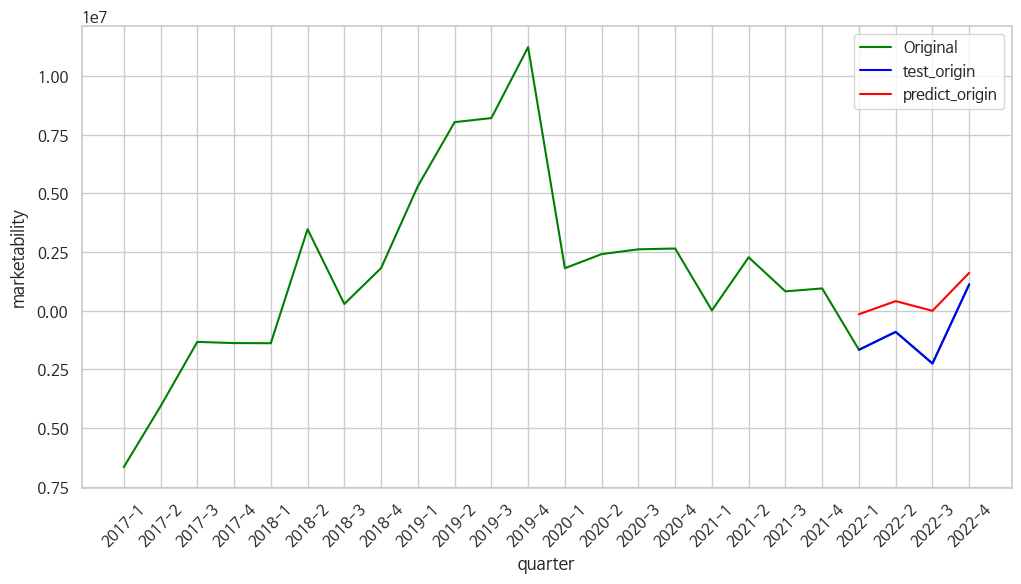

In [70]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [71]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -1.390703e+06
std      7.207526e+05
min     -2.245044e+06
25%     -1.697389e+06
50%     -1.412612e+06
75%     -1.105926e+06
max     -4.925415e+05
dtype: float64

In [72]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 24ms/step
[[0.4099234]]
--------------------------------------------------------------------------------
예측된 시장성  : 667559.0625 


## 23년 1분기 순점포증감률 예측

In [73]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_junkfood[['성장성', '분기당_매출_금액', '시장성']]
y = sin_junkfood.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성   분기당_매출_금액           시장성
0   1.000000  4187187100 -6.666712e+06
1   1.154863  4835625661 -4.077555e+06
2   0.905852  4380363389 -1.332540e+06
3   1.029782  4510821236 -1.383189e+06
4   0.872184  3934265191 -1.389288e+06
5   1.354920  5330616280  3.468321e+06
6   0.825396  4399869669  2.827236e+05
7   1.113630  4899827210  1.811155e+06
8   0.980558  4804562568  5.300686e+06
9   1.015705  4880018931  8.028357e+06
10  1.071350  5228206221  8.202359e+06
11  1.045784  5467576400  1.122510e+07
12  0.692378  3785628101  1.805991e+06
13  0.977722  3701290402  2.406211e+06
14  0.967866  3582353768  2.611041e+06
15  0.889712  3187264236  2.644881e+06
16  0.754105  2403530600  6.835053e+03
17  1.239623  2979472413  2.270456e+06
18  0.852514  2540041933  8.195975e+05
19  1.038847  2638716109  9.447096e+05
20  0.819832  2163303723 -1.669795e+06
21  1.231578  2664276916 -9.062759e+05
22  0.967198  2576884633 -2.253539e+06
23  1.186543  3057584360  1.117470e+06
-------------------------

In [74]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [75]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [76]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.41479707 0.12516549 0.24665884]
 [0.74586174 0.27064372 0.4350696 ]]


In [77]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [78]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [79]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2344
Epoch 1: val_loss improved from inf to 0.31659, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.2344 - val_loss: 0.3166
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2225
Epoch 2: val_loss improved from 0.31659 to 0.30500, saving model to stock_model.h5
1/1 [==============================] - 0s 100ms/step - loss: 0.2225 - val_loss: 0.3050
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2112
Epoch 3: val_loss improved from 0.30500 to 0.29385, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.2112 - val_loss: 0.2939
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2004
Epoch 4: val_loss improved from 0.29385 to 0.28311, saving model to stock_model.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.2004 - val_loss: 0.2831
Epoch 5/100
1/1 [================

In [80]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 799ms/step
[[0.3469449 ]
 [0.3463614 ]
 [0.32184476]
 [0.38502997]]


In [81]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.426555,0.346945
2022-2,0.615869,0.346361
2022-3,0.615869,0.321845
2022-4,0.124337,0.385030


In [82]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_junkfood의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.426555,0.346945,-1.149425,-2.116138,0.966713
2022-2,0.615869,0.346361,1.149425,-2.123224,3.272649
2022-3,0.615869,0.321845,1.149425,-2.420931,3.570357
2022-4,0.124337,0.385030,-4.819277,-1.653669,-3.165608


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


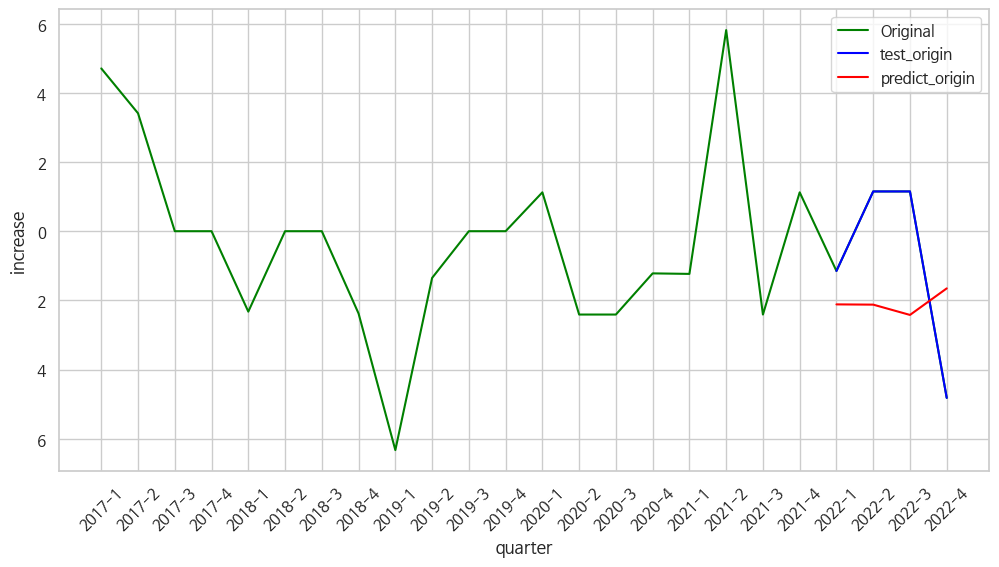

In [83]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [84]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     1.161028
std      3.110270
min     -3.165608
25%     -0.066367
50%      2.119681
75%      3.347076
max      3.570357
dtype: float64

In [85]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 27ms/step
[[0.36802974]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.8601038455963135 


## 원본 데이터에 예측값 추가하기

In [86]:
print(sales)
print(growth)
print(marketability)
print(increase)

3035338800.0
0.85943145
667559.06
-1.8601038


In [87]:
sin_junkfood.loc[24] = ['2023-1', '패스트푸드점', sales, growth, increase, marketability]

<ipython-input-87-3eb57e4e66bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_junkfood.loc[24] = ['2023-1', '패스트푸드점', sales, growth, increase, marketability]


In [88]:
sin_junkfood

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,패스트푸드점,4.187187e+09,1.000000,4.705882,-6.666712e+06
1,2017-2,패스트푸드점,4.835626e+09,1.154863,3.409091,-4.077555e+06
2,2017-3,패스트푸드점,4.380363e+09,0.905852,0.000000,-1.332540e+06
3,2017-4,패스트푸드점,4.510821e+09,1.029782,0.000000,-1.383189e+06
4,2018-1,패스트푸드점,3.934265e+09,0.872184,-2.325581,-1.389288e+06
5,2018-2,패스트푸드점,5.330616e+09,1.354920,0.000000,3.468321e+06
6,2018-3,패스트푸드점,4.399870e+09,0.825396,0.000000,2.827236e+05
7,2018-4,패스트푸드점,4.899827e+09,1.113630,-2.380952,1.811155e+06
8,2019-1,패스트푸드점,4.804563e+09,0.980558,-6.329114,5.300686e+06
9,2019-2,패스트푸드점,4.880019e+09,1.015705,-1.351351,8.028357e+06


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [89]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_junkfood[['성장성', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -6.666712e+06  4.705882
1   1.154863 -4.077555e+06  3.409091
2   0.905852 -1.332540e+06  0.000000
3   1.029782 -1.383189e+06  0.000000
4   0.872184 -1.389288e+06 -2.325581
5   1.354920  3.468321e+06  0.000000
6   0.825396  2.827236e+05  0.000000
7   1.113630  1.811155e+06 -2.380952
8   0.980558  5.300686e+06 -6.329114
9   1.015705  8.028357e+06 -1.351351
10  1.071350  8.202359e+06  0.000000
11  1.045784  1.122510e+07  0.000000
12  0.692378  1.805991e+06  1.123596
13  0.977722  2.406211e+06 -2.409639
14  0.967866  2.611041e+06 -2.409639
15  0.889712  2.644881e+06 -1.219512
16  0.754105  6.835053e+03 -1.234568
17  1.239623  2.270456e+06  5.813953
18  0.852514  8.195975e+05 -2.409639
19  1.038847  9.447096e+05  1.123596
20  0.819832 -1.669795e+06 -1.149425
21  1.231578 -9.062759e+05  1.149425
22  0.967198 -2.253539e+06  1.149425
23  1.186543  1.117470e+06 -4.819277
24  0.859431  6.675591e+05 -1.860104
--------------------------------------

In [90]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [91]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.74586174 0.4350696  0.12433735]
 [0.25214031 0.4099234  0.36802975]]


In [92]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [93]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [94]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6541
Epoch 1: val_loss improved from inf to 0.08301, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.6541 - val_loss: 0.0830
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6354
Epoch 2: val_loss improved from 0.08301 to 0.07765, saving model to stock_model.h5
1/1 [==============================] - 0s 190ms/step - loss: 0.6354 - val_loss: 0.0776
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6172
Epoch 3: val_loss improved from 0.07765 to 0.07262, saving model to stock_model.h5
1/1 [==============================] - 0s 145ms/step - loss: 0.6172 - val_loss: 0.0726
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5996
Epoch 4: val_loss improved from 0.07262 to 0.06789, saving model to stock_model.h5
1/1 [==============================] - 0s 110ms/step - loss: 0.5996 - val_loss: 0.0679
Epoch 5/100
1/1 [==============

In [95]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 836ms/step
[[0.22925818]
 [0.21975067]
 [0.2572748 ]
 [0.22543857]]


In [96]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.151614,0.229258
2022-3,0.125165,0.219751
2022-4,0.270644,0.257275
2023-1,0.263911,0.225439


In [97]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_junkfood의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.151614,0.229258,2.664277e+09,2.920835e+09,-256558412.0
2022-3,0.125165,0.219751,2.576885e+09,2.889420e+09,-312535399.0
2022-4,0.270644,0.257275,3.057584e+09,3.013410e+09,44174568.0
2023-1,0.263911,0.225439,3.035339e+09,2.908214e+09,127124480.0


In [98]:
df_test = df_test.reset_index()

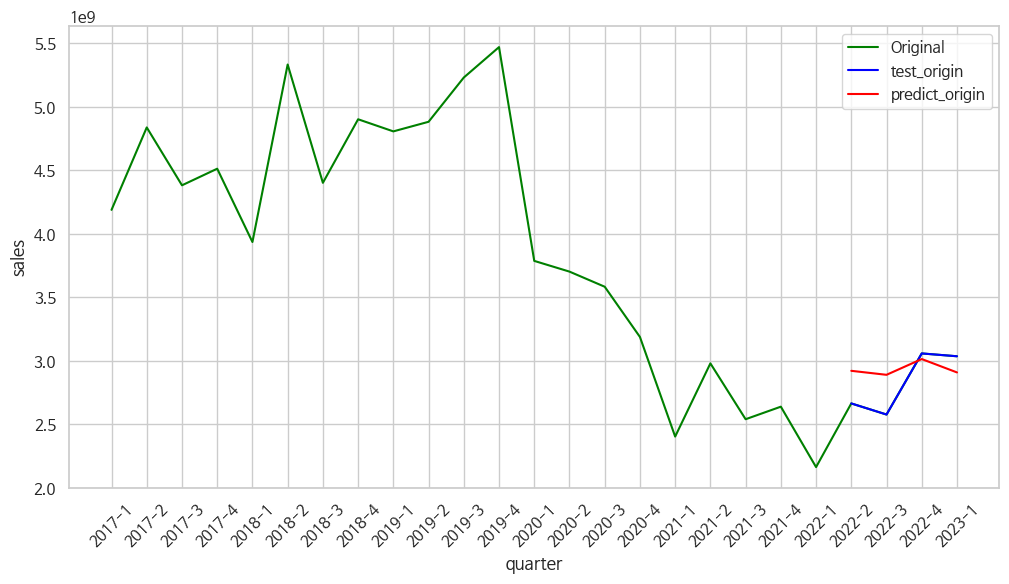

In [99]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [100]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -9.944869e+07
std      2.176024e+08
min     -3.125354e+08
25%     -2.705527e+08
50%     -1.061919e+08
75%      6.491205e+07
max      1.271245e+08
dtype: float64

In [101]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 31ms/step
[[0.21137471]]
--------------------------------------------------------------------------------
예측된 매출  : 2861743360.0 


### 성장성

In [102]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   4.187187e+09 -6.666712e+06  4.705882
1   4.835626e+09 -4.077555e+06  3.409091
2   4.380363e+09 -1.332540e+06  0.000000
3   4.510821e+09 -1.383189e+06  0.000000
4   3.934265e+09 -1.389288e+06 -2.325581
5   5.330616e+09  3.468321e+06  0.000000
6   4.399870e+09  2.827236e+05  0.000000
7   4.899827e+09  1.811155e+06 -2.380952
8   4.804563e+09  5.300686e+06 -6.329114
9   4.880019e+09  8.028357e+06 -1.351351
10  5.228206e+09  8.202359e+06  0.000000
11  5.467576e+09  1.122510e+07  0.000000
12  3.785628e+09  1.805991e+06  1.123596
13  3.701290e+09  2.406211e+06 -2.409639
14  3.582354e+09  2.611041e+06 -2.409639
15  3.187264e+09  2.644881e+06 -1.219512
16  2.403531e+09  6.835053e+03 -1.234568
17  2.979472e+09  2.270456e+06  5.813953
18  2.540042e+09  8.195975e+05 -2.409639
19  2.638716e+09  9.447096e+05  1.123596
20  2.163304e+09 -1.669795e+06 -1.149425
21  2.664277e+09 -9.062759e+05  1.149425
22  2.576885e+09 -2.253539e+06  1.149425
23  3.057584e+09

In [103]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [104]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.27064372 0.4350696  0.12433735]
 [0.26391134 0.4099234  0.36802975]]


In [105]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [106]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [107]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2915
Epoch 1: val_loss improved from inf to 0.20159, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.2915 - val_loss: 0.2016
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2793
Epoch 2: val_loss improved from 0.20159 to 0.19314, saving model to stock_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.2793 - val_loss: 0.1931
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2676
Epoch 3: val_loss improved from 0.19314 to 0.18502, saving model to stock_model.h5
1/1 [==============================] - 0s 119ms/step - loss: 0.2676 - val_loss: 0.1850
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2564
Epoch 4: val_loss improved from 0.18502 to 0.17721, saving model to stock_model.h5
1/1 [==============================] - 0s 112ms/step - loss: 0.2564 - val_loss: 0.1772
Epoch 5/100
1/1 [==============

In [108]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 838ms/step
[[0.30673632]
 [0.28298223]
 [0.32207108]
 [0.3028994 ]]


In [109]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.813835,0.306736
2022-3,0.414797,0.282982
2022-4,0.745862,0.322071
2023-1,0.252140,0.302899


In [110]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 3].values       # 성장성이 sin_junkfood의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.813835,0.306736,1.231578,0.895604,0.335974
2022-3,0.414797,0.282982,0.967198,0.879866,0.087333
2022-4,0.745862,0.322071,1.186543,0.905764,0.280779
2023-1,0.252140,0.302899,0.859431,0.893061,-0.033630


In [111]:
df_test = df_test.reset_index()

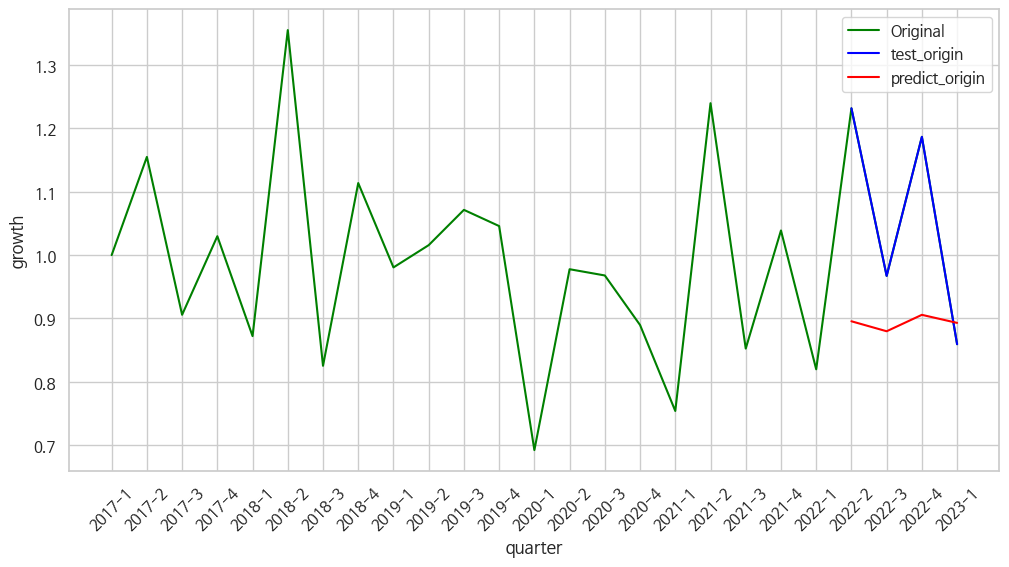

In [112]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [113]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.167614
std      0.171363
min     -0.033630
25%      0.057092
50%      0.184056
75%      0.294578
max      0.335974
dtype: float64

In [114]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 29ms/step
[[0.29520515]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8879637122154236 


### 시장성

In [115]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_junkfood.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   4.187187e+09  1.000000  4.705882
1   4.835626e+09  1.154863  3.409091
2   4.380363e+09  0.905852  0.000000
3   4.510821e+09  1.029782  0.000000
4   3.934265e+09  0.872184 -2.325581
5   5.330616e+09  1.354920  0.000000
6   4.399870e+09  0.825396  0.000000
7   4.899827e+09  1.113630 -2.380952
8   4.804563e+09  0.980558 -6.329114
9   4.880019e+09  1.015705 -1.351351
10  5.228206e+09  1.071350  0.000000
11  5.467576e+09  1.045784  0.000000
12  3.785628e+09  0.692378  1.123596
13  3.701290e+09  0.977722 -2.409639
14  3.582354e+09  0.967866 -2.409639
15  3.187264e+09  0.889712 -1.219512
16  2.403531e+09  0.754105 -1.234568
17  2.979472e+09  1.239623  5.813953
18  2.540042e+09  0.852514 -2.409639
19  2.638716e+09  1.038847  1.123596
20  2.163304e+09  0.819832 -1.149425
21  2.664277e+09  1.231578  1.149425
22  2.576885e+09  0.967198  1.149425
23  3.057584e+09  1.186543 -4.819277
24  3.035339e+09  0.859431 -1.860104
--------------------------------------

In [116]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [117]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.27064372 0.74586174 0.12433735]
 [0.26391134 0.25214031 0.36802975]]


In [118]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [119]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [120]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3975
Epoch 1: val_loss improved from inf to 0.21247, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3975 - val_loss: 0.2125
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3823
Epoch 2: val_loss improved from 0.21247 to 0.20325, saving model to stock_model.h5
1/1 [==============================] - 0s 112ms/step - loss: 0.3823 - val_loss: 0.2032
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3677
Epoch 3: val_loss improved from 0.20325 to 0.19437, saving model to stock_model.h5
1/1 [==============================] - 0s 146ms/step - loss: 0.3677 - val_loss: 0.1944
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3537
Epoch 4: val_loss improved from 0.19437 to 0.18580, saving model to stock_model.h5
1/1 [==============================] - 0s 132ms/step - loss: 0.3537 - val_loss: 0.1858
Epoch 5/100
1/1 [==============

In [121]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 2s 2s/step
[[0.38199204]
 [0.35569507]
 [0.4357221 ]
 [0.39689732]]


In [122]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.321959,0.381992
2022-3,0.246659,0.355695
2022-4,0.435070,0.435722
2023-1,0.409923,0.396897


In [123]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 5].values       # 시장성이 sin_junkfood의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.321959,0.381992,-9.062759e+05,1.678165e+05,-1.074092e+06
2022-3,0.246659,0.355695,-2.253539e+06,-3.026840e+05,-1.950855e+06
2022-4,0.435070,0.435722,1.117470e+06,1.129145e+06,-1.167472e+04
2023-1,0.409923,0.396897,6.675591e+05,4.344988e+05,2.330603e+05


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


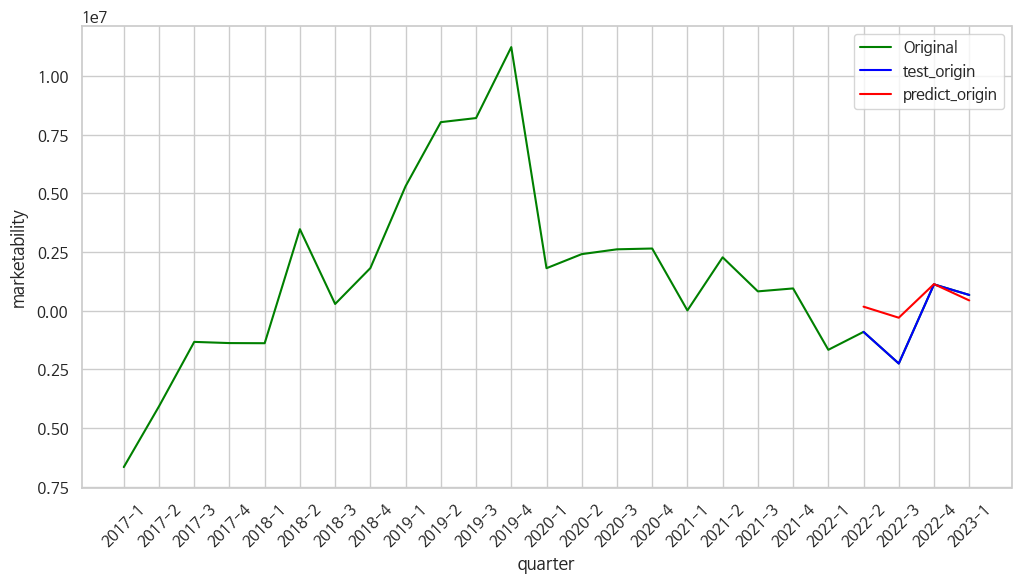

In [124]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [125]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -7.008905e+05
std      1.008129e+06
min     -1.950855e+06
25%     -1.293283e+06
50%     -5.428835e+05
75%      4.950903e+04
max      2.330603e+05
dtype: float64

In [126]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 28ms/step
[[0.3879615]]
--------------------------------------------------------------------------------
예측된 시장성  : 274620.96875 


### 순점포증감률

In [127]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '성장성', '시장성']]
y = sin_junkfood.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   4.187187e+09  1.000000 -6.666712e+06
1   4.835626e+09  1.154863 -4.077555e+06
2   4.380363e+09  0.905852 -1.332540e+06
3   4.510821e+09  1.029782 -1.383189e+06
4   3.934265e+09  0.872184 -1.389288e+06
5   5.330616e+09  1.354920  3.468321e+06
6   4.399870e+09  0.825396  2.827236e+05
7   4.899827e+09  1.113630  1.811155e+06
8   4.804563e+09  0.980558  5.300686e+06
9   4.880019e+09  1.015705  8.028357e+06
10  5.228206e+09  1.071350  8.202359e+06
11  5.467576e+09  1.045784  1.122510e+07
12  3.785628e+09  0.692378  1.805991e+06
13  3.701290e+09  0.977722  2.406211e+06
14  3.582354e+09  0.967866  2.611041e+06
15  3.187264e+09  0.889712  2.644881e+06
16  2.403531e+09  0.754105  6.835053e+03
17  2.979472e+09  1.239623  2.270456e+06
18  2.540042e+09  0.852514  8.195975e+05
19  2.638716e+09  1.038847  9.447096e+05
20  2.163304e+09  0.819832 -1.669795e+06
21  2.664277e+09  1.231578 -9.062759e+05
22  2.576885e+09  0.967198 -2.253539e+06
23  3.057584e+09

In [128]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [129]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.27064372 0.74586174 0.4350696 ]
 [0.26391134 0.25214031 0.4099234 ]]


In [130]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [131]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [132]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2451
Epoch 1: val_loss improved from inf to 0.28885, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2451 - val_loss: 0.2888
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2328
Epoch 2: val_loss improved from 0.28885 to 0.27897, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.2328 - val_loss: 0.2790
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2210
Epoch 3: val_loss improved from 0.27897 to 0.26937, saving model to stock_model.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.2210 - val_loss: 0.2694
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2097
Epoch 4: val_loss improved from 0.26937 to 0.26002, saving model to stock_model.h5
1/1 [==============================] - 0s 114ms/step - loss: 0.2097 - val_loss: 0.2600
Epoch 5/100
1/1 [================

In [133]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.33019796]
 [0.30331185]
 [0.35575432]
 [0.34870934]]


In [134]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.615869,0.330198
2022-3,0.615869,0.303312
2022-4,0.124337,0.355754
2023-1,0.368030,0.348709


In [135]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_junkfood의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.615869,0.330198,1.149425,-2.319498,3.468923
2022-3,0.615869,0.303312,1.149425,-2.645977,3.795403
2022-4,0.124337,0.355754,-4.819277,-2.009165,-2.810112
2023-1,0.368030,0.348709,-1.860104,-2.094713,0.234609


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


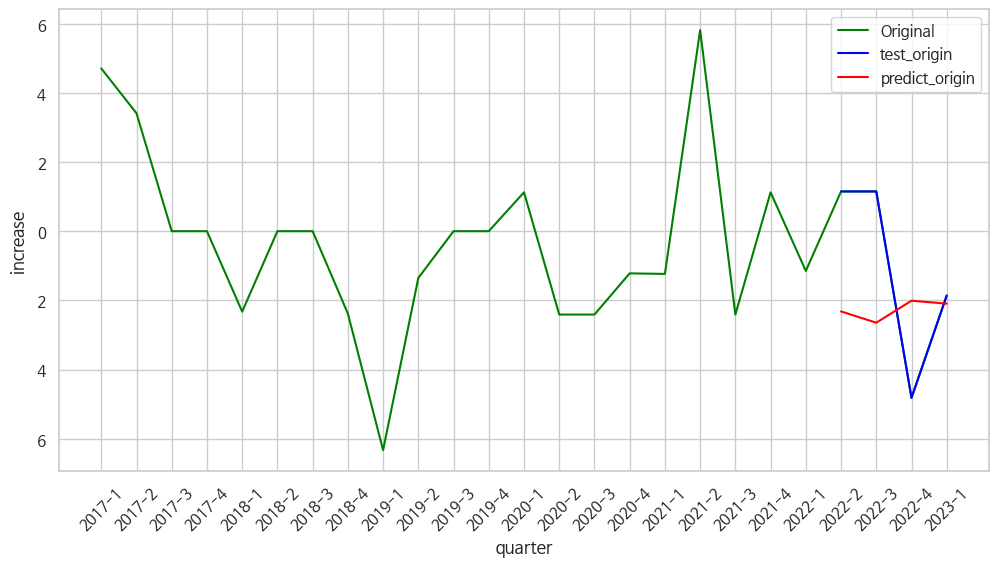

In [136]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [137]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     1.172206
std      3.103440
min     -2.810112
25%     -0.526571
50%      1.851766
75%      3.550543
max      3.795403
dtype: float64

In [138]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 23ms/step
[[0.39839178]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.4914156198501587 


### 추가


In [139]:
sin_junkfood.loc[25] = ['2023-2', '패스트푸드점', sales, growth, increase, marketability]

<ipython-input-139-8d45e19b1b17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_junkfood.loc[25] = ['2023-2', '패스트푸드점', sales, growth, increase, marketability]


In [140]:
sin_junkfood

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,패스트푸드점,4.187187e+09,1.000000,4.705882,-6.666712e+06
1,2017-2,패스트푸드점,4.835626e+09,1.154863,3.409091,-4.077555e+06
2,2017-3,패스트푸드점,4.380363e+09,0.905852,0.000000,-1.332540e+06
3,2017-4,패스트푸드점,4.510821e+09,1.029782,0.000000,-1.383189e+06
4,2018-1,패스트푸드점,3.934265e+09,0.872184,-2.325581,-1.389288e+06
5,2018-2,패스트푸드점,5.330616e+09,1.354920,0.000000,3.468321e+06
6,2018-3,패스트푸드점,4.399870e+09,0.825396,0.000000,2.827236e+05
7,2018-4,패스트푸드점,4.899827e+09,1.113630,-2.380952,1.811155e+06
8,2019-1,패스트푸드점,4.804563e+09,0.980558,-6.329114,5.300686e+06
9,2019-2,패스트푸드점,4.880019e+09,1.015705,-1.351351,8.028357e+06


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [141]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_junkfood[['성장성', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -6.666712e+06  4.705882
1   1.154863 -4.077555e+06  3.409091
2   0.905852 -1.332540e+06  0.000000
3   1.029782 -1.383189e+06  0.000000
4   0.872184 -1.389288e+06 -2.325581
5   1.354920  3.468321e+06  0.000000
6   0.825396  2.827236e+05  0.000000
7   1.113630  1.811155e+06 -2.380952
8   0.980558  5.300686e+06 -6.329114
9   1.015705  8.028357e+06 -1.351351
10  1.071350  8.202359e+06  0.000000
11  1.045784  1.122510e+07  0.000000
12  0.692378  1.805991e+06  1.123596
13  0.977722  2.406211e+06 -2.409639
14  0.967866  2.611041e+06 -2.409639
15  0.889712  2.644881e+06 -1.219512
16  0.754105  6.835053e+03 -1.234568
17  1.239623  2.270456e+06  5.813953
18  0.852514  8.195975e+05 -2.409639
19  1.038847  9.447096e+05  1.123596
20  0.819832 -1.669795e+06 -1.149425
21  1.231578 -9.062759e+05  1.149425
22  0.967198 -2.253539e+06  1.149425
23  1.186543  1.117470e+06 -4.819277
24  0.859431  6.675591e+05 -1.860104
25  0.887964  2.746210e+05 -1.491416
-

In [142]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [143]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.25214031 0.4099234  0.36802975]
 [0.2952051  0.38796151 0.39839179]]


In [144]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [145]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [146]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6208
Epoch 1: val_loss improved from inf to 0.05619, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.6208 - val_loss: 0.0562
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6025
Epoch 2: val_loss improved from 0.05619 to 0.05197, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.6025 - val_loss: 0.0520
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5849
Epoch 3: val_loss improved from 0.05197 to 0.04804, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.5849 - val_loss: 0.0480
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5677
Epoch 4: val_loss improved from 0.04804 to 0.04438, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.5677 - val_loss: 0.0444
Epoch 5/100
1/1 [================

In [147]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.17299117]
 [0.20113814]
 [0.17655668]
 [0.16543533]]


In [148]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.125165,0.172991
2022-4,0.270644,0.201138
2023-1,0.263911,0.176557
2023-2,0.211375,0.165435


In [149]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_junkfood의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.125165,0.172991,2.576885e+09,2.734914e+09,-158029159.0
2022-4,0.270644,0.201138,3.057584e+09,2.827919e+09,229665512.0
2023-1,0.263911,0.176557,3.035339e+09,2.746695e+09,288643584.0
2023-2,0.211375,0.165435,2.861743e+09,2.709947e+09,151796224.0


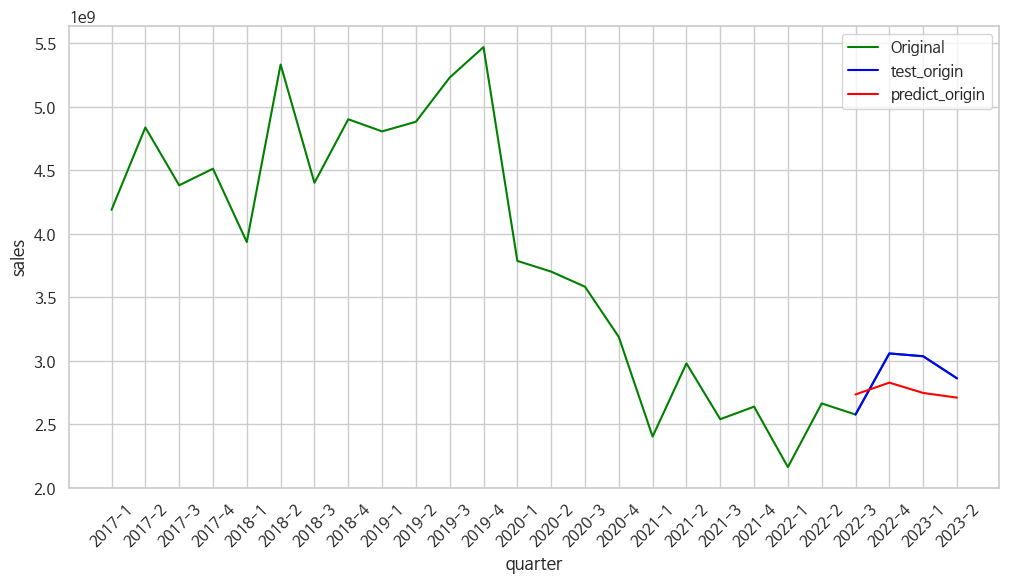

In [150]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [151]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.280190e+08
std      1.987638e+08
min     -1.580292e+08
25%      7.433988e+07
50%      1.907309e+08
75%      2.444100e+08
max      2.886436e+08
dtype: float64

In [152]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 61ms/step
[[0.15709774]]
--------------------------------------------------------------------------------
예측된 매출  : 2682397440.0 


### 성장성

In [153]:
X = sin_junkfood[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   4.187187e+09 -6.666712e+06  4.705882
1   4.835626e+09 -4.077555e+06  3.409091
2   4.380363e+09 -1.332540e+06  0.000000
3   4.510821e+09 -1.383189e+06  0.000000
4   3.934265e+09 -1.389288e+06 -2.325581
5   5.330616e+09  3.468321e+06  0.000000
6   4.399870e+09  2.827236e+05  0.000000
7   4.899827e+09  1.811155e+06 -2.380952
8   4.804563e+09  5.300686e+06 -6.329114
9   4.880019e+09  8.028357e+06 -1.351351
10  5.228206e+09  8.202359e+06  0.000000
11  5.467576e+09  1.122510e+07  0.000000
12  3.785628e+09  1.805991e+06  1.123596
13  3.701290e+09  2.406211e+06 -2.409639
14  3.582354e+09  2.611041e+06 -2.409639
15  3.187264e+09  2.644881e+06 -1.219512
16  2.403531e+09  6.835053e+03 -1.234568
17  2.979472e+09  2.270456e+06  5.813953
18  2.540042e+09  8.195975e+05 -2.409639
19  2.638716e+09  9.447096e+05  1.123596
20  2.163304e+09 -1.669795e+06 -1.149425
21  2.664277e+09 -9.062759e+05  1.149425
22  2.576885e+09 -2.253539e+06  1.149425
23  3.057584e+09

In [154]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [155]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.26391134 0.4099234  0.36802975]
 [0.2113747  0.38796151 0.39839179]]


In [156]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [157]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [158]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2857
Epoch 1: val_loss improved from inf to 0.26069, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.2857 - val_loss: 0.2607
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2734
Epoch 2: val_loss improved from 0.26069 to 0.25199, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.2734 - val_loss: 0.2520
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2616
Epoch 3: val_loss improved from 0.25199 to 0.24357, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.2616 - val_loss: 0.2436
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2503
Epoch 4: val_loss improved from 0.24357 to 0.23540, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.2503 - val_loss: 0.2354
Epoch 5/100
1/1 [================

In [159]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 821ms/step
[[0.32366487]
 [0.36860266]
 [0.34641644]
 [0.33713567]]


In [160]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.414797,0.323665
2022-4,0.745862,0.368603
2023-1,0.252140,0.346416
2023-2,0.295205,0.337136


In [161]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 3].values       # 성장성이 sin_junkfood의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.414797,0.323665,0.967198,0.906820,0.060379
2022-4,0.745862,0.368603,1.186543,0.936593,0.249950
2023-1,0.252140,0.346416,0.859431,0.921893,-0.062462
2023-2,0.295205,0.337136,0.887964,0.915744,-0.027781


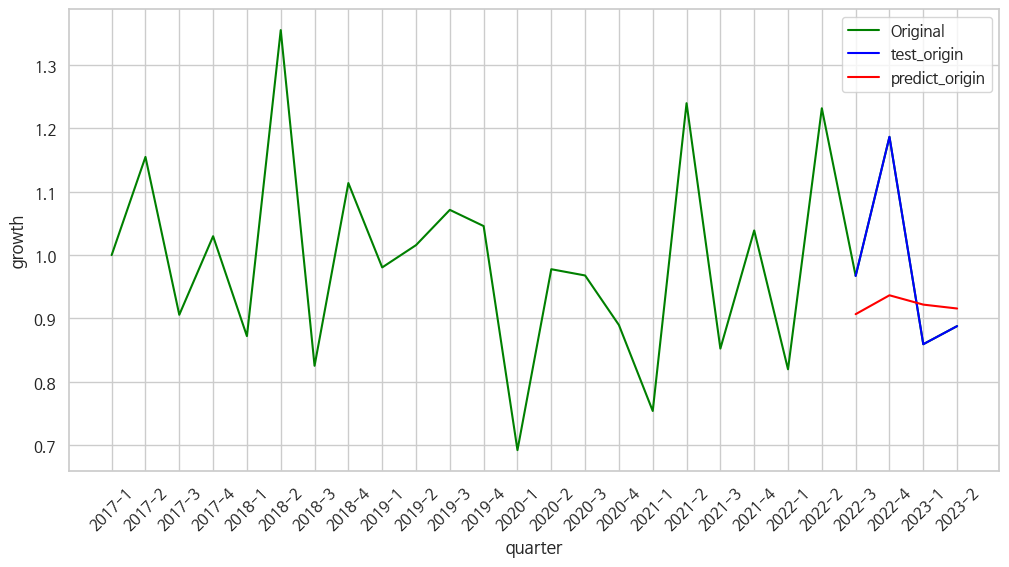

In [162]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [163]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.055022
std      0.139862
min     -0.062462
25%     -0.036451
50%      0.016299
75%      0.107772
max      0.249950
dtype: float64

In [164]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 24ms/step
[[0.36009106]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9309534430503845 


### 시장성

In [165]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_junkfood.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   4.187187e+09  1.000000  4.705882
1   4.835626e+09  1.154863  3.409091
2   4.380363e+09  0.905852  0.000000
3   4.510821e+09  1.029782  0.000000
4   3.934265e+09  0.872184 -2.325581
5   5.330616e+09  1.354920  0.000000
6   4.399870e+09  0.825396  0.000000
7   4.899827e+09  1.113630 -2.380952
8   4.804563e+09  0.980558 -6.329114
9   4.880019e+09  1.015705 -1.351351
10  5.228206e+09  1.071350  0.000000
11  5.467576e+09  1.045784  0.000000
12  3.785628e+09  0.692378  1.123596
13  3.701290e+09  0.977722 -2.409639
14  3.582354e+09  0.967866 -2.409639
15  3.187264e+09  0.889712 -1.219512
16  2.403531e+09  0.754105 -1.234568
17  2.979472e+09  1.239623  5.813953
18  2.540042e+09  0.852514 -2.409639
19  2.638716e+09  1.038847  1.123596
20  2.163304e+09  0.819832 -1.149425
21  2.664277e+09  1.231578  1.149425
22  2.576885e+09  0.967198  1.149425
23  3.057584e+09  1.186543 -4.819277
24  3.035339e+09  0.859431 -1.860104
25  2.861743e+09  0.887964 -1.491416
-

In [166]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [167]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.26391134 0.25214031 0.36802975]
 [0.2113747  0.2952051  0.39839179]]


In [168]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [169]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [170]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3879
Epoch 1: val_loss improved from inf to 0.19297, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3879 - val_loss: 0.1930
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3728
Epoch 2: val_loss improved from 0.19297 to 0.18464, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.3728 - val_loss: 0.1846
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3583
Epoch 3: val_loss improved from 0.18464 to 0.17662, saving model to stock_model.h5
1/1 [==============================] - 0s 78ms/step - loss: 0.3583 - val_loss: 0.1766
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3443
Epoch 4: val_loss improved from 0.17662 to 0.16887, saving model to stock_model.h5
1/1 [==============================] - 0s 108ms/step - loss: 0.3443 - val_loss: 0.1689
Epoch 5/100
1/1 [================

In [171]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 868ms/step
[[0.35567436]
 [0.4354893 ]
 [0.39657298]
 [0.38727483]]


In [172]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.246659,0.355674
2022-4,0.435070,0.435489
2023-1,0.409923,0.396573
2023-2,0.387962,0.387275


In [173]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 5].values       # 시장성이 sin_junkfood의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.246659,0.355674,-2.253539e+06,-3.030545e+05,-1.950485e+06
2022-4,0.435070,0.435489,1.117470e+06,1.124979e+06,-7.509215e+03
2023-1,0.409923,0.396573,6.675591e+05,4.286958e+05,2.388633e+05
2023-2,0.387962,0.387275,2.746210e+05,2.623351e+05,1.228584e+04


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


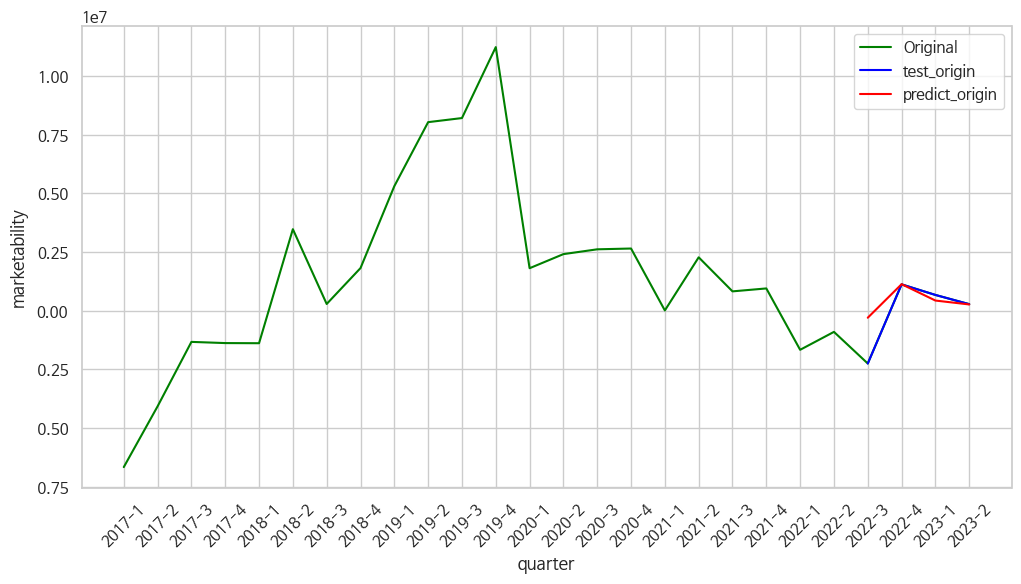

In [174]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [175]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -4.267112e+05
std      1.021979e+06
min     -1.950485e+06
25%     -4.932531e+05
50%      2.388314e+03
75%      6.893020e+04
max      2.388633e+05
dtype: float64

In [176]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 25ms/step
[[0.3782068]]
--------------------------------------------------------------------------------
예측된 시장성  : 100091.4453125 


### 순점포증감률

In [177]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '성장성', '시장성']]
y = sin_junkfood.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   4.187187e+09  1.000000 -6.666712e+06
1   4.835626e+09  1.154863 -4.077555e+06
2   4.380363e+09  0.905852 -1.332540e+06
3   4.510821e+09  1.029782 -1.383189e+06
4   3.934265e+09  0.872184 -1.389288e+06
5   5.330616e+09  1.354920  3.468321e+06
6   4.399870e+09  0.825396  2.827236e+05
7   4.899827e+09  1.113630  1.811155e+06
8   4.804563e+09  0.980558  5.300686e+06
9   4.880019e+09  1.015705  8.028357e+06
10  5.228206e+09  1.071350  8.202359e+06
11  5.467576e+09  1.045784  1.122510e+07
12  3.785628e+09  0.692378  1.805991e+06
13  3.701290e+09  0.977722  2.406211e+06
14  3.582354e+09  0.967866  2.611041e+06
15  3.187264e+09  0.889712  2.644881e+06
16  2.403531e+09  0.754105  6.835053e+03
17  2.979472e+09  1.239623  2.270456e+06
18  2.540042e+09  0.852514  8.195975e+05
19  2.638716e+09  1.038847  9.447096e+05
20  2.163304e+09  0.819832 -1.669795e+06
21  2.664277e+09  1.231578 -9.062759e+05
22  2.576885e+09  0.967198 -2.253539e+06
23  3.057584e+09

In [178]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [179]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.26391134 0.25214031 0.4099234 ]
 [0.2113747  0.2952051  0.38796151]]


In [180]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [181]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [182]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2348
Epoch 1: val_loss improved from inf to 0.32405, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2348 - val_loss: 0.3240
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2227
Epoch 2: val_loss improved from 0.32405 to 0.31391, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.2227 - val_loss: 0.3139
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2112
Epoch 3: val_loss improved from 0.31391 to 0.30399, saving model to stock_model.h5
1/1 [==============================] - 0s 111ms/step - loss: 0.2112 - val_loss: 0.3040
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2001
Epoch 4: val_loss improved from 0.30399 to 0.29431, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.2001 - val_loss: 0.2943
Epoch 5/100
1/1 [==============

In [183]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 891ms/step
[[0.29441714]
 [0.34475064]
 [0.33816534]
 [0.385868  ]]


In [184]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.615869,0.294417
2022-4,0.124337,0.344751
2023-1,0.368030,0.338165
2023-2,0.398392,0.385868


In [185]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_junkfood의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.615869,0.294417,1.149425,-2.753987,3.903412
2022-4,0.124337,0.344751,-4.819277,-2.142784,-2.676493
2023-1,0.368030,0.338165,-1.860104,-2.222749,0.362645
2023-2,0.398392,0.385868,-1.491416,-1.643493,0.152077


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


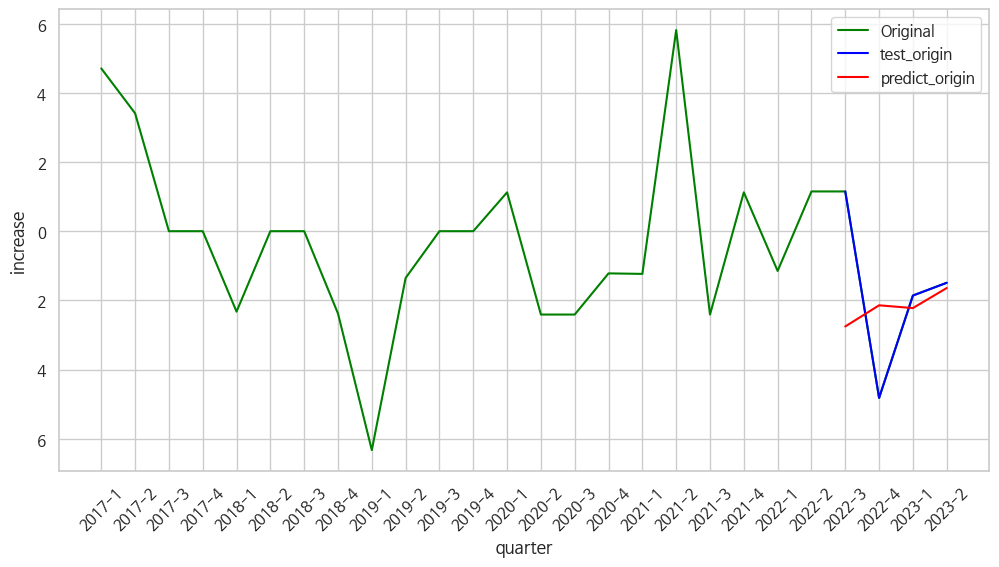

In [186]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [187]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.435410
std      2.695462
min     -2.676493
25%     -0.555066
50%      0.257361
75%      1.247837
max      3.903412
dtype: float64

In [188]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 28ms/step
[[0.34216312]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.174204111099243 


### 추가

In [189]:
sin_junkfood.loc[26] = ['2023-3', '패스트푸드점', sales, growth, increase, marketability]

<ipython-input-189-08ed52b3a60b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_junkfood.loc[26] = ['2023-3', '패스트푸드점', sales, growth, increase, marketability]


In [190]:
sin_junkfood

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,패스트푸드점,4.187187e+09,1.000000,4.705882,-6.666712e+06
1,2017-2,패스트푸드점,4.835626e+09,1.154863,3.409091,-4.077555e+06
2,2017-3,패스트푸드점,4.380363e+09,0.905852,0.000000,-1.332540e+06
3,2017-4,패스트푸드점,4.510821e+09,1.029782,0.000000,-1.383189e+06
4,2018-1,패스트푸드점,3.934265e+09,0.872184,-2.325581,-1.389288e+06
5,2018-2,패스트푸드점,5.330616e+09,1.354920,0.000000,3.468321e+06
6,2018-3,패스트푸드점,4.399870e+09,0.825396,0.000000,2.827236e+05
7,2018-4,패스트푸드점,4.899827e+09,1.113630,-2.380952,1.811155e+06
8,2019-1,패스트푸드점,4.804563e+09,0.980558,-6.329114,5.300686e+06
9,2019-2,패스트푸드점,4.880019e+09,1.015705,-1.351351,8.028357e+06


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [191]:
### X / y 데이터 생성
X = sin_junkfood[['성장성', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -6.666712e+06  4.705882
1   1.154863 -4.077555e+06  3.409091
2   0.905852 -1.332540e+06  0.000000
3   1.029782 -1.383189e+06  0.000000
4   0.872184 -1.389288e+06 -2.325581
5   1.354920  3.468321e+06  0.000000
6   0.825396  2.827236e+05  0.000000
7   1.113630  1.811155e+06 -2.380952
8   0.980558  5.300686e+06 -6.329114
9   1.015705  8.028357e+06 -1.351351
10  1.071350  8.202359e+06  0.000000
11  1.045784  1.122510e+07  0.000000
12  0.692378  1.805991e+06  1.123596
13  0.977722  2.406211e+06 -2.409639
14  0.967866  2.611041e+06 -2.409639
15  0.889712  2.644881e+06 -1.219512
16  0.754105  6.835053e+03 -1.234568
17  1.239623  2.270456e+06  5.813953
18  0.852514  8.195975e+05 -2.409639
19  1.038847  9.447096e+05  1.123596
20  0.819832 -1.669795e+06 -1.149425
21  1.231578 -9.062759e+05  1.149425
22  0.967198 -2.253539e+06  1.149425
23  1.186543  1.117470e+06 -4.819277
24  0.859431  6.675591e+05 -1.860104
25  0.887964  2.746210e+05 -1.491416
2

In [192]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [193]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.2952051  0.38796151 0.39839179]
 [0.36009108 0.37820679 0.34216312]]


In [194]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [195]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [196]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6208
Epoch 1: val_loss improved from inf to 0.05197, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.6208 - val_loss: 0.0520
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6025
Epoch 2: val_loss improved from 0.05197 to 0.04790, saving model to stock_model.h5
1/1 [==============================] - 0s 130ms/step - loss: 0.6025 - val_loss: 0.0479
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5849
Epoch 3: val_loss improved from 0.04790 to 0.04413, saving model to stock_model.h5
1/1 [==============================] - 0s 132ms/step - loss: 0.5849 - val_loss: 0.0441
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5677
Epoch 4: val_loss improved from 0.04413 to 0.04063, saving model to stock_model.h5
1/1 [==============================] - 0s 136ms/step - loss: 0.5677 - val_loss: 0.0406
Epoch 5/100
1/1 [==============

In [197]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.20113814]
 [0.17655668]
 [0.16543533]
 [0.15709773]]


In [198]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.270644,0.201138
2023-1,0.263911,0.176557
2023-2,0.211375,0.165435
2023-3,0.157098,0.157098


In [199]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_junkfood의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.270644,0.201138,3.057584e+09,2.827919e+09,229665512.0
2023-1,0.263911,0.176557,3.035339e+09,2.746695e+09,288643584.0
2023-2,0.211375,0.165435,2.861743e+09,2.709947e+09,151796224.0
2023-3,0.157098,0.157098,2.682397e+09,2.682397e+09,0.0


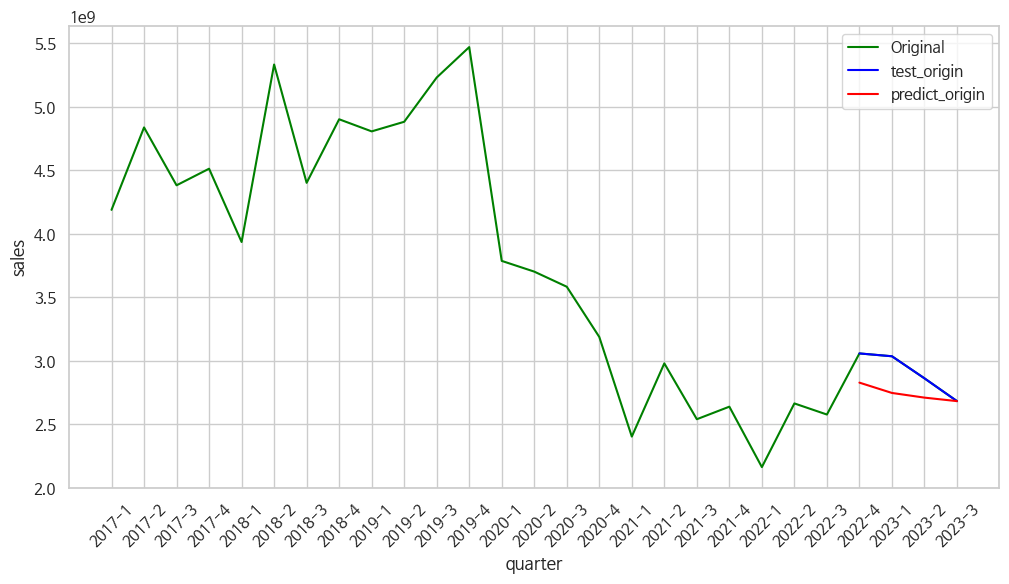

In [200]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [201]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.675263e+08
std      1.249576e+08
min      0.000000e+00
25%      1.138472e+08
50%      1.907309e+08
75%      2.444100e+08
max      2.886436e+08
dtype: float64

In [202]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 42ms/step
[[0.1598301]]
--------------------------------------------------------------------------------
예측된 매출  : 2691426048.0 


### 성장성

In [203]:
X = sin_junkfood[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   4.187187e+09 -6.666712e+06  4.705882
1   4.835626e+09 -4.077555e+06  3.409091
2   4.380363e+09 -1.332540e+06  0.000000
3   4.510821e+09 -1.383189e+06  0.000000
4   3.934265e+09 -1.389288e+06 -2.325581
5   5.330616e+09  3.468321e+06  0.000000
6   4.399870e+09  2.827236e+05  0.000000
7   4.899827e+09  1.811155e+06 -2.380952
8   4.804563e+09  5.300686e+06 -6.329114
9   4.880019e+09  8.028357e+06 -1.351351
10  5.228206e+09  8.202359e+06  0.000000
11  5.467576e+09  1.122510e+07  0.000000
12  3.785628e+09  1.805991e+06  1.123596
13  3.701290e+09  2.406211e+06 -2.409639
14  3.582354e+09  2.611041e+06 -2.409639
15  3.187264e+09  2.644881e+06 -1.219512
16  2.403531e+09  6.835053e+03 -1.234568
17  2.979472e+09  2.270456e+06  5.813953
18  2.540042e+09  8.195975e+05 -2.409639
19  2.638716e+09  9.447096e+05  1.123596
20  2.163304e+09 -1.669795e+06 -1.149425
21  2.664277e+09 -9.062759e+05  1.149425
22  2.576885e+09 -2.253539e+06  1.149425
23  3.057584e+09

In [204]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [205]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.2113747  0.38796151 0.39839179]
 [0.15709772 0.37820679 0.34216312]]


In [206]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [207]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [208]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2857
Epoch 1: val_loss improved from inf to 0.25167, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2857 - val_loss: 0.2517
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2734
Epoch 2: val_loss improved from 0.25167 to 0.24316, saving model to stock_model.h5
1/1 [==============================] - 0s 117ms/step - loss: 0.2734 - val_loss: 0.2432
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2616
Epoch 3: val_loss improved from 0.24316 to 0.23491, saving model to stock_model.h5
1/1 [==============================] - 0s 120ms/step - loss: 0.2616 - val_loss: 0.2349
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2503
Epoch 4: val_loss improved from 0.23491 to 0.22690, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.2503 - val_loss: 0.2269
Epoch 5/100
1/1 [==============

In [209]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 867ms/step
[[0.36860266]
 [0.34641644]
 [0.33713567]
 [0.3600911 ]]


In [210]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.745862,0.368603
2023-1,0.252140,0.346416
2023-2,0.295205,0.337136
2023-3,0.360091,0.360091


In [211]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 3].values       # 성장성이 sin_junkfood의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.745862,0.368603,1.186543,0.936593,0.249950
2023-1,0.252140,0.346416,0.859431,0.921893,-0.062462
2023-2,0.295205,0.337136,0.887964,0.915744,-0.027781
2023-3,0.360091,0.360091,0.930953,0.930953,0.000000


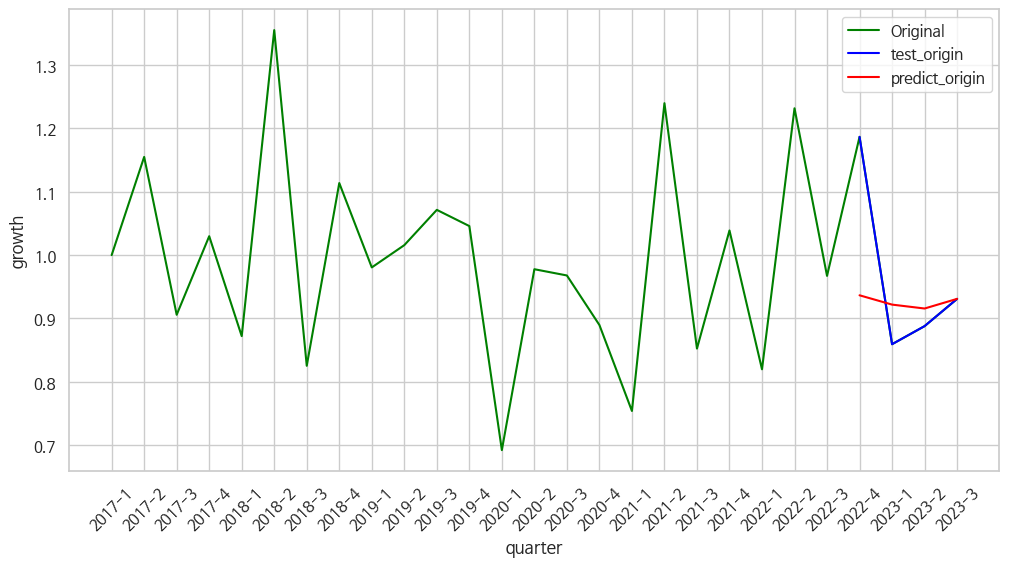

In [212]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [213]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.039927
std      0.142328
min     -0.062462
25%     -0.036451
50%     -0.013890
75%      0.062488
max      0.249950
dtype: float64

In [214]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 25ms/step
[[0.34570318]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9214208722114563 


###시장성

In [215]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_junkfood.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   4.187187e+09  1.000000  4.705882
1   4.835626e+09  1.154863  3.409091
2   4.380363e+09  0.905852  0.000000
3   4.510821e+09  1.029782  0.000000
4   3.934265e+09  0.872184 -2.325581
5   5.330616e+09  1.354920  0.000000
6   4.399870e+09  0.825396  0.000000
7   4.899827e+09  1.113630 -2.380952
8   4.804563e+09  0.980558 -6.329114
9   4.880019e+09  1.015705 -1.351351
10  5.228206e+09  1.071350  0.000000
11  5.467576e+09  1.045784  0.000000
12  3.785628e+09  0.692378  1.123596
13  3.701290e+09  0.977722 -2.409639
14  3.582354e+09  0.967866 -2.409639
15  3.187264e+09  0.889712 -1.219512
16  2.403531e+09  0.754105 -1.234568
17  2.979472e+09  1.239623  5.813953
18  2.540042e+09  0.852514 -2.409639
19  2.638716e+09  1.038847  1.123596
20  2.163304e+09  0.819832 -1.149425
21  2.664277e+09  1.231578  1.149425
22  2.576885e+09  0.967198  1.149425
23  3.057584e+09  1.186543 -4.819277
24  3.035339e+09  0.859431 -1.860104
25  2.861743e+09  0.887964 -1.491416
2

In [216]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [217]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.2113747  0.2952051  0.39839179]
 [0.15709772 0.36009108 0.34216312]]


In [218]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [219]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [220]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3879
Epoch 1: val_loss improved from inf to 0.17911, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3879 - val_loss: 0.1791
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3728
Epoch 2: val_loss improved from 0.17911 to 0.17121, saving model to stock_model.h5
1/1 [==============================] - 0s 132ms/step - loss: 0.3728 - val_loss: 0.1712
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3583
Epoch 3: val_loss improved from 0.17121 to 0.16360, saving model to stock_model.h5
1/1 [==============================] - 0s 128ms/step - loss: 0.3583 - val_loss: 0.1636
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3443
Epoch 4: val_loss improved from 0.16360 to 0.15625, saving model to stock_model.h5
1/1 [==============================] - 0s 135ms/step - loss: 0.3443 - val_loss: 0.1563
Epoch 5/100
1/1 [==============

In [221]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 816ms/step
[[0.4354893 ]
 [0.39657298]
 [0.38727483]
 [0.3782068 ]]


In [222]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.435070,0.435489
2023-1,0.409923,0.396573
2023-2,0.387962,0.387275
2023-3,0.378207,0.378207


In [223]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 5].values       # 시장성이 sin_junkfood의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.435070,0.435489,1.117470e+06,1.124979e+06,-7509.215201
2023-1,0.409923,0.396573,6.675591e+05,4.286958e+05,238863.281250
2023-2,0.387962,0.387275,2.746210e+05,2.623351e+05,12285.843750
2023-3,0.378207,0.378207,1.000914e+05,1.000914e+05,0.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


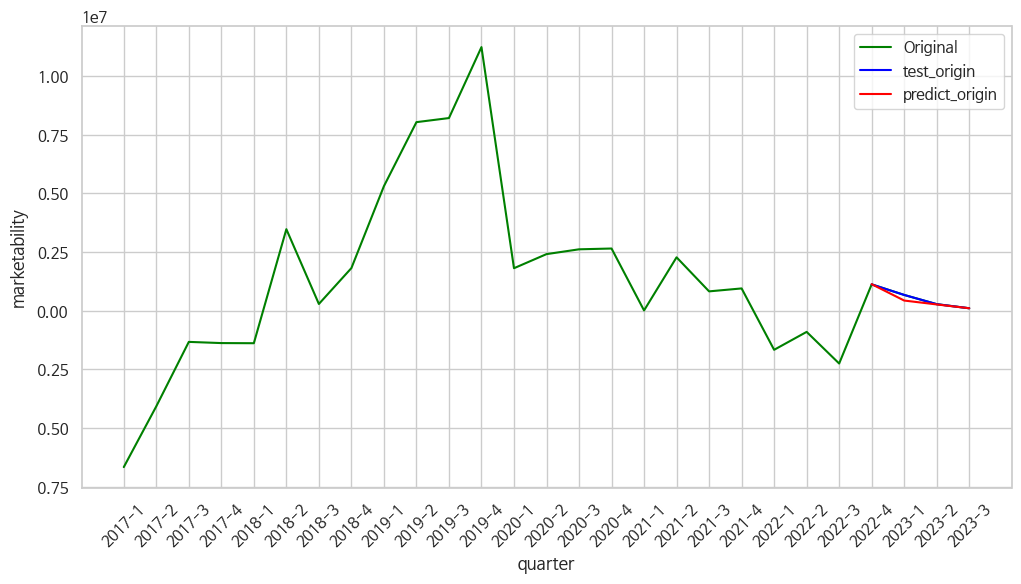

In [224]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [225]:
### error의 요약 통계량
error.describe()

count         4.000000
mean      60909.977450
std      118915.790916
min       -7509.215201
25%       -1877.303800
50%        6142.921875
75%       68930.203125
max      238863.281250
dtype: float64

In [226]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 25ms/step
[[0.36850905]]
--------------------------------------------------------------------------------
예측된 시장성  : -73418.5859375 


### 순점포증감률

In [227]:
### X / y 데이터 생성
X = sin_junkfood[['분기당_매출_금액', '성장성', '시장성']]
y = sin_junkfood.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   4.187187e+09  1.000000 -6.666712e+06
1   4.835626e+09  1.154863 -4.077555e+06
2   4.380363e+09  0.905852 -1.332540e+06
3   4.510821e+09  1.029782 -1.383189e+06
4   3.934265e+09  0.872184 -1.389288e+06
5   5.330616e+09  1.354920  3.468321e+06
6   4.399870e+09  0.825396  2.827236e+05
7   4.899827e+09  1.113630  1.811155e+06
8   4.804563e+09  0.980558  5.300686e+06
9   4.880019e+09  1.015705  8.028357e+06
10  5.228206e+09  1.071350  8.202359e+06
11  5.467576e+09  1.045784  1.122510e+07
12  3.785628e+09  0.692378  1.805991e+06
13  3.701290e+09  0.977722  2.406211e+06
14  3.582354e+09  0.967866  2.611041e+06
15  3.187264e+09  0.889712  2.644881e+06
16  2.403531e+09  0.754105  6.835053e+03
17  2.979472e+09  1.239623  2.270456e+06
18  2.540042e+09  0.852514  8.195975e+05
19  2.638716e+09  1.038847  9.447096e+05
20  2.163304e+09  0.819832 -1.669795e+06
21  2.664277e+09  1.231578 -9.062759e+05
22  2.576885e+09  0.967198 -2.253539e+06
23  3.057584e+09

In [228]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [229]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.2113747  0.2952051  0.38796151]
 [0.15709772 0.36009108 0.37820679]]


In [230]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [231]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [232]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2348
Epoch 1: val_loss improved from inf to 0.33206, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2348 - val_loss: 0.3321
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2227
Epoch 2: val_loss improved from 0.33206 to 0.32190, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.2227 - val_loss: 0.3219
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2112
Epoch 3: val_loss improved from 0.32190 to 0.31195, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.2112 - val_loss: 0.3120
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2001
Epoch 4: val_loss improved from 0.31195 to 0.30223, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.2001 - val_loss: 0.3022
Epoch 5/100
1/1 [=================

In [233]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 837ms/step
[[0.34475064]
 [0.33816534]
 [0.385868  ]
 [0.34216315]]


In [234]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.124337,0.344751
2023-1,0.368030,0.338165
2023-2,0.398392,0.385868
2023-3,0.342163,0.342163


In [235]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_junkfood의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.124337,0.344751,-4.819277,-2.142784,-2.676493e+00
2023-1,0.368030,0.338165,-1.860104,-2.222749,3.626454e-01
2023-2,0.398392,0.385868,-1.491416,-1.643493,1.520770e-01
2023-3,0.342163,0.342163,-2.174204,-2.174204,-4.768372e-07


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


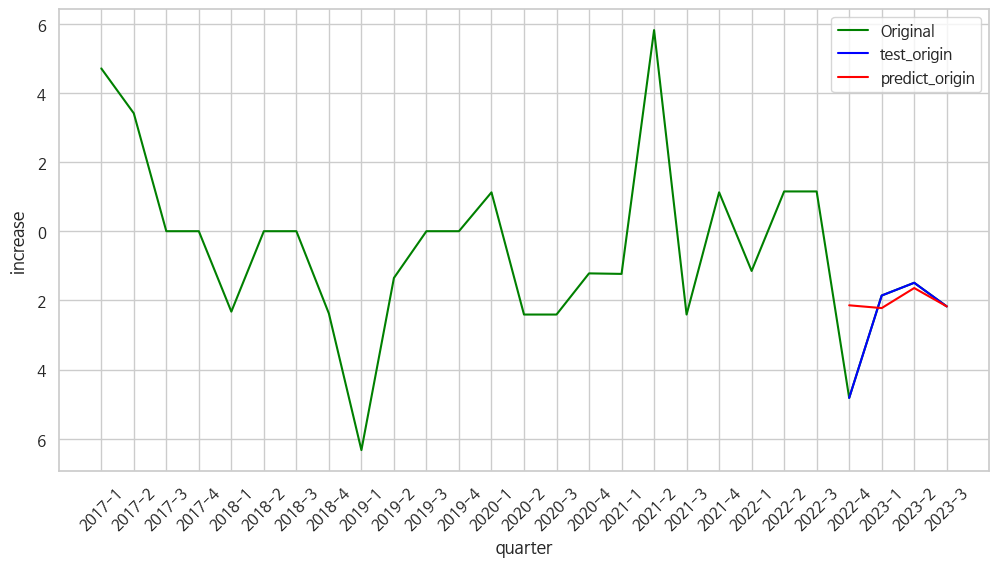

In [236]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [237]:
### error의 요약 통계량
error.describe()

count    4.000000
mean    -0.540443
std      1.431775
min     -2.676493
25%     -0.669124
50%      0.076038
75%      0.204719
max      0.362645
dtype: float64

In [238]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 22ms/step
[[0.33289868]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.286702871322632 


### 추가

In [239]:
sin_junkfood.loc[27] = ['2023-4', '패스트푸드점', sales, growth, increase, marketability]

<ipython-input-239-ffa35b021bd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_junkfood.loc[27] = ['2023-4', '패스트푸드점', sales, growth, increase, marketability]


In [240]:
final_sin_junkfood = sin_junkfood
final_sin_junkfood

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,패스트푸드점,4.187187e+09,1.000000,4.705882,-6.666712e+06
1,2017-2,패스트푸드점,4.835626e+09,1.154863,3.409091,-4.077555e+06
2,2017-3,패스트푸드점,4.380363e+09,0.905852,0.000000,-1.332540e+06
3,2017-4,패스트푸드점,4.510821e+09,1.029782,0.000000,-1.383189e+06
4,2018-1,패스트푸드점,3.934265e+09,0.872184,-2.325581,-1.389288e+06
5,2018-2,패스트푸드점,5.330616e+09,1.354920,0.000000,3.468321e+06
6,2018-3,패스트푸드점,4.399870e+09,0.825396,0.000000,2.827236e+05
7,2018-4,패스트푸드점,4.899827e+09,1.113630,-2.380952,1.811155e+06
8,2019-1,패스트푸드점,4.804563e+09,0.980558,-6.329114,5.300686e+06
9,2019-2,패스트푸드점,4.880019e+09,1.015705,-1.351351,8.028357e+06


## 최종결과

In [241]:
### X / y 데이터 생성
X = sin_junkfood[['성장성', '시장성', '순점포증감률']]
y = sin_junkfood.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -6.666712e+06  4.705882
1   1.154863 -4.077555e+06  3.409091
2   0.905852 -1.332540e+06  0.000000
3   1.029782 -1.383189e+06  0.000000
4   0.872184 -1.389288e+06 -2.325581
5   1.354920  3.468321e+06  0.000000
6   0.825396  2.827236e+05  0.000000
7   1.113630  1.811155e+06 -2.380952
8   0.980558  5.300686e+06 -6.329114
9   1.015705  8.028357e+06 -1.351351
10  1.071350  8.202359e+06  0.000000
11  1.045784  1.122510e+07  0.000000
12  0.692378  1.805991e+06  1.123596
13  0.977722  2.406211e+06 -2.409639
14  0.967866  2.611041e+06 -2.409639
15  0.889712  2.644881e+06 -1.219512
16  0.754105  6.835053e+03 -1.234568
17  1.239623  2.270456e+06  5.813953
18  0.852514  8.195975e+05 -2.409639
19  1.038847  9.447096e+05  1.123596
20  0.819832 -1.669795e+06 -1.149425
21  1.231578 -9.062759e+05  1.149425
22  0.967198 -2.253539e+06  1.149425
23  1.186543  1.117470e+06 -4.819277
24  0.859431  6.675591e+05 -1.860104
25  0.887964  2.746210e+05 -1.491416
2

In [242]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [243]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (26, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (26, 1)
[[0.36009108 0.37820679 0.34216312]
 [0.34570322 0.36850905 0.33289868]]


In [244]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (22, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (22, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [245]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [246]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5890
Epoch 1: val_loss improved from inf to 0.03868, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.5890 - val_loss: 0.0387
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5714
Epoch 2: val_loss improved from 0.03868 to 0.03490, saving model to stock_model.h5
1/1 [==============================] - 0s 150ms/step - loss: 0.5714 - val_loss: 0.0349
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5544
Epoch 3: val_loss improved from 0.03490 to 0.03141, saving model to stock_model.h5
1/1 [==============================] - 0s 144ms/step - loss: 0.5544 - val_loss: 0.0314
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5379
Epoch 4: val_loss improved from 0.03141 to 0.02821, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.5379 - val_loss: 0.0282
Epoch 5/100
1/1 [==============

In [247]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 892ms/step
[[0.16196442]
 [0.15138379]
 [0.14430243]
 [0.14676875]]


In [248]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_junkfood.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2023-1,0.263911,0.161964
2023-2,0.211375,0.151384
2023-3,0.157098,0.144302
2023-4,0.159830,0.146769


In [249]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_junkfood.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_junkfood의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2023-1,0.263911,0.161964,3.035339e+09,2.698478e+09,336860416.0
2023-2,0.211375,0.151384,2.861743e+09,2.663517e+09,198226176.0
2023-3,0.157098,0.144302,2.682397e+09,2.640118e+09,42279168.0
2023-4,0.159830,0.146769,2.691426e+09,2.648268e+09,43158272.0


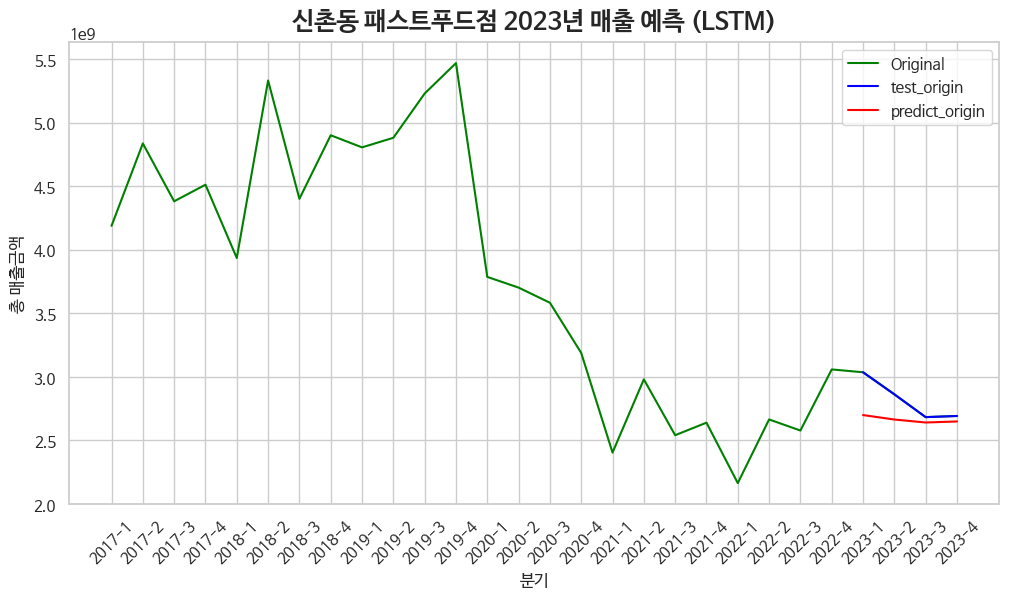

In [250]:
df_test = df_test.reset_index()

### 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(sin_junkfood['분기'], sin_junkfood['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.title('신촌동 패스트푸드점 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xticks(rotation=45)
plt.xlabel('분기')
plt.ylabel('총 매출금액')
plt.legend()
plt.show()